In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from random import sample
from math import ceil,sin,cos, atan2, pi, sqrt
import pandas as pd
from cartopy import crs, feature
import requests
from bs4 import BeautifulSoup

In [2]:
import geocoder # pip install geocoder
def locat_coord(Name,province):
    g = geocoder.bing(Name+' '+province, key=APIkey)
    results = g.json
    return results['lat'], results['lng']

popmin = 1e4 #minimum population to consider

In [3]:
APIkey = 'Apex3rPr59EmaffYxKvl4Ypz0tjZBthExXiz1Ha_pBDtD3Q7XL7l2nMs2Ba8fwZm '

# Pulling official data from Wikipedia 2021 updated census
url = 'https://en.wikipedia.org/wiki/List_of_municipalities_in_British_Columbia'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
indiatable=soup.find('table',{'class':"wikitable"})
Data=pd.read_html(str(indiatable))
# convert list to dataframe
Data=pd.DataFrame(Data[0])
Data = Data.iloc[:-10]

Name = Data['Name'].iloc[:,0]
Pop = Data['2021 Canadian census[11]'].iloc[:,0]

d = {'Name': Name, 'Population':np.array(Pop)}
UrbanBC = pd.DataFrame(data=d)

In [4]:
# # Pulling official data from Washington Population Dataset
# url = 'https://mrsc.org/Home/Research-Tools/Washington-City-and-Town-Profiles.aspx'
# response = requests.get(url)
# soup = BeautifulSoup(response.text, 'html.parser')
# indiatable=soup.find('table',{'class':"table-interactive table table-bordered"})
# Data=pd.read_html(str(indiatable))
# # convert list to dataframe
# Data=pd.DataFrame(Data[0])
# Data = Data.iloc[0::3]

# Name = Data['City']
# Pop = Data['Population (2022)']
# popu = []
# for po in Pop:
#     popu.append(int(po))
# d = {'Name': Name, 'Population':popu}
# UrbanWA = pd.DataFrame(data=d)

In [5]:
UrbanWA = pd.read_csv('Washington_pop.csv',header=0)

In [6]:
#Getting municipalities coordinates from geocoder database
def get_coords(Data,province):
    lat = []
    lon = []
    for i in range(Data.shape[0]):
        try:
            latn,lonn = locat_coord(Data.Name.iloc[i],province)
            lat.append(latn)
            lon.append(lonn)
        except TypeError:
            if Data.Population.iloc[i]> popmin:
                lat.append(input('Introduce Latitude from '+Data.Name.iloc[i]))
                lon.append(input('Introduce Longitude from '+Data.Name.iloc[i]))
            else:
                print(Data.Name.iloc[i]+ ' coordinates not found.')
                lat.append(0)
                lon.append(0)
    return lat, lon

UrbanBC['Latitude'],UrbanBC['Longitude'] = get_coords(UrbanBC,'BC')     
UrbanWA['Latitude'],UrbanWA['Longitude'] = get_coords(UrbanWA,'Washington')    

Montrose coordinates not found.


In [7]:
UrbanBC = UrbanBC[UrbanBC.Latitude < 50.1]
UrbanBC = UrbanBC[UrbanBC.Longitude > -125.4]
UrbanBC = UrbanBC[UrbanBC.Longitude < -122]
UrbanWA = UrbanWA[UrbanWA.Latitude > 47]
UrbanWA = UrbanWA[UrbanWA.Longitude > -124]
UrbanWA = UrbanWA[UrbanWA.Longitude < -122]
frames = [UrbanBC, UrbanWA]

Urban = pd.concat(frames)

In [8]:
poptot =np.sum(Urban.Population)

In [9]:
Urban = Urban[Urban.Population > popmin]

In [10]:
print(np.sum(Urban.Population)*100/poptot)

97.30156857041709


In [11]:
import xarray as xr
from salishsea_tools import river_202108 as Rivers
rivers = Rivers.prop_dict
#bathy = xr.open_dataset('~/MOAD/grid/grid/bathymetry_201702.nc')
bathy = xr.open_dataset('~/MOAD/grid/bathymetry_202108.nc')

In [12]:
River_Name = []
River_Watershed = []
Latitude = []
Longitude = []
for watershed in (rivers.keys()):
    for name in rivers[watershed].keys():
        River_Name.append(name)
        River_Watershed.append(watershed)
        Latitude.append(bathy.nav_lat[rivers[watershed][name]['i'],rivers[watershed][name]['j']].values)
        Longitude.append(bathy.nav_lon[rivers[watershed][name]['i'],rivers[watershed][name]['j']].values)
d = {'Name': River_Name, 'Watershed':River_Watershed,'Latitude':Latitude,'Longitude':Longitude}
Rivers_list = pd.DataFrame(data=d)

In [13]:
#fixing main branch Fraser River Location
Rivers_list.iloc[133].Latitude = 49.121495
Rivers_list.iloc[133].Longitude = -123.247933

#Add runoff location Victoria harbor area
new_row = pd.DataFrame({'Name':'Victoria Harbor','Watershed':'jdf','Latitude':48.416950,'Longitude': -123.395355}, index=[0])
Rivers_list = pd.concat([new_row,Rivers_list.loc[:]]).reset_index(drop=True)

#Add runoff location Victoria Oak Bay
new_row = pd.DataFrame({'Name':'Victoria Oak Bay','Watershed':'jdf','Latitude':48.431265,'Longitude': -123.299794}, index=[0])
Rivers_list = pd.concat([new_row,Rivers_list.loc[:]]).reset_index(drop=True)

#Add runoff location north branch fraser river
new_row = pd.DataFrame({'Name':'Fraser North','Watershed':'fraser','Latitude':49.227044,'Longitude': -123.219523}, index=[0])
Rivers_list = pd.concat([new_row,Rivers_list.loc[:]]).reset_index(drop=True)

#Add runoff location Oak Harbor
new_row = pd.DataFrame({'Name':'Oak Harbor','Watershed':'skagit','Latitude':48.266780,'Longitude': -122.643507}, index=[0])
Rivers_list = pd.concat([new_row,Rivers_list.loc[:]]).reset_index(drop=True)

#Add runoff location Edmonds ferry terminal
new_row = pd.DataFrame({'Name':'Edmonds port','Watershed':'puget','Latitude':47.815885,'Longitude': -122.385012}, index=[0])
Rivers_list = pd.concat([new_row,Rivers_list.loc[:]]).reset_index(drop=True)

In [14]:
colors_wsheds= {
'howe':'#F6D1BF', 
'jdf':'#AAA67E', 
'puget':'#FCF7B4',
'skagit':'#ACC752', 
'fraser':'#C0DCD1', 
'evi_n':'#B2C391', 
'jervis':'#CFCAD1', 
'toba':'#949B9D', 
'bute':'#AAD3E8', 
'evi_s':'#F0DCB4'}
cc = []
for i in range(Rivers_list.shape[0]):
    cc.append(colors_wsheds[Rivers_list.Watershed.iloc[i]])

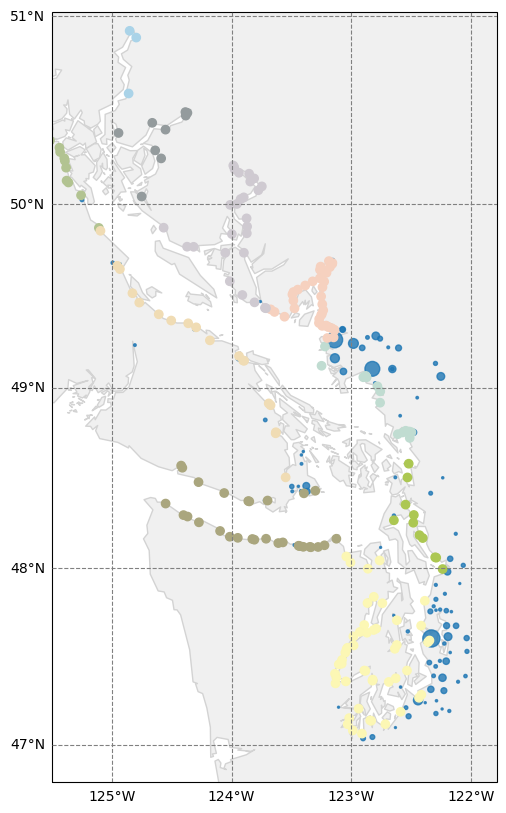

In [15]:
lonmin= Urban.Longitude.min()-0.25
lonmax= Urban.Longitude.max()+0.25
latmin= Urban.Latitude.min()-0.25
latmax= Urban.Latitude.max()+1
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='#F0F0F0',edgecolor='lightgray'),zorder=1)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False

sc=plt.scatter(Urban.Longitude,Urban.Latitude,transform=crs.PlateCarree(),zorder=2,alpha=0.8,s=Urban.Population/5e3)
riv=plt.scatter(Rivers_list.Longitude,Rivers_list.Latitude,transform=crs.PlateCarree(),zorder=2,c = cc)

In [16]:
Wclass= {
'howe':1, 
'jdf':2, 
'puget':3,
'skagit':4, 
'fraser':5, 
'evi_n':6, 
'jervis':7, 
'toba':8, 
'bute':9, 
'evi_s':10}
cclas = []
for i in range(Rivers_list.shape[0]):
    cclas.append(Wclass[Rivers_list.Watershed.iloc[i]])

In [17]:
puget = Rivers_list[Rivers_list.Watershed=='puget']
puget = puget[puget.Longitude > -122.5]

In [18]:
Rivers_list = Rivers_list[['Name','Watershed','Latitude','Longitude']]

In [19]:
#fix
def River_dist(City,river_list=Rivers_list):
    rivers_loc = river_list.iloc[:,2:]
    city_loc = City[2:]
    dist_2 = np.sum((rivers_loc - city_loc)**2, axis=1)

    #dist_check = dist_2-dist_2[np.argmin(dist_2)]
    #dist_check = 100*dist_check/dist_2[np.argmin(dist_2)]
    #dist_check[np.argmin(dist_2)] = 1e6
    #if np.min(dist_check) > 5:
    return np.argmin(dist_2)
    #else:
    #    return [np.argmin(dist_2),np.argmin(dist_check)]
Lat_riv = []
Lon_riv = []
for i in range(Urban.shape[0]):
    try:
        Lat_riv.append(np.ndarray.item(Rivers_list.iloc[River_dist(Urban.iloc[i,:]),2]))
        Lon_riv.append(np.ndarray.item(Rivers_list.iloc[River_dist(Urban.iloc[i,:]),3]))
    except TypeError:
        Lat_riv.append(Rivers_list.iloc[River_dist(Urban.iloc[i,:]),2])
        Lon_riv.append(Rivers_list.iloc[River_dist(Urban.iloc[i,:]),3])

In [20]:
Urban['Latitude closest_river'] = Lat_riv
Urban['Longitude closest_river'] = Lon_riv

In [21]:
def check_closestriver(n):
    n_neighbors = 5
    # we only take the first two features. We could avoid this ugly
    # slicing by using a two-dim dataset
    X = Rivers_list.iloc[:,2:4]
    y = cclas

    # Create color maps
    cmap_light = ListedColormap(['#F6D1BF','#AAA67E','#FCF7B4','#ACC752','#C0DCD1','#B2C391','#CFCAD1','#949B9D','#AAD3E8','#F0DCB4'])
    cmap_bold = ['#F6D1BF','#AAA67E','#FCF7B4','#ACC752','#C0DCD1','#B2C391','#CFCAD1','#949B9D','#AAD3E8','#F0DCB4']

    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")
    clf.fit(X, y)

    lonmin= Urban.Longitude.min()-0.25
    lonmax= Urban.Longitude.max()+0.25
    latmin= Urban.Latitude.min()-0.25
    latmax= Urban.Latitude.max()+1
    fig, ax = plt.subplots(figsize=(7, 6), subplot_kw={'projection': crs.Mercator()})
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
    ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='#F0F0F0',edgecolor='lightgray'),zorder=1)
    ax.add_feature(feature.OCEAN,zorder=3)
    gl = ax.gridlines(
        linestyle='--', color='gray', draw_labels=True,
        xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
    gl.top_labels, gl.right_labels = False, False
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel='Latitude',
        ylabel='Longitude',
        alpha=0.5,
        transform=crs.PlateCarree()
    )
    # Plot also the training points
    cit=plt.scatter(Urban.Longitude,Urban.Latitude,zorder=5,alpha=0.8,s=Urban.Population/1e3,transform=crs.PlateCarree())
    riv=plt.scatter(Rivers_list.Longitude,Rivers_list.Latitude,transform=crs.PlateCarree(),zorder=4,c = cc,edgecolors='k')
    plt.title(Urban.Name.iloc[n])

    cit=plt.scatter(Urban.Longitude.iloc[n],Urban.Latitude.iloc[n],zorder=6,transform=crs.PlateCarree(),c = 'r')
    cit=plt.scatter(Urban['Longitude closest_river'].iloc[n],Urban['Latitude closest_river'].iloc[n],zorder=6,transform=crs.PlateCarree(),c = 'k')

    plt.show()

#check_closestriver(41)

In [22]:
# 1 north fraser
# 0,4,6,8,9,10,12,15 fraser
# 3,7 victoria
#check_closestriver(15)

In [23]:
def fix_rivers(n,rivername):
    try:
        for ni in n:
            Urban.iat[ni,4] = Rivers_list[Rivers_list.Name == rivername].iat[0,2]
            Urban.iat[ni,5] = Rivers_list[Rivers_list.Name == rivername].iat[0,3]
    except TypeError:
        Urban.iat[n,4] = Rivers_list[Rivers_list.Name == rivername].iat[0,2]
        Urban.iat[n,5] = Rivers_list[Rivers_list.Name == rivername].iat[0,3]
    return 

In [24]:
# fix_rivers([0,1,3,8,9,11,13,16],'Fraser')
# fix_rivers([6,18],'Victoria Harbor')
# fix_rivers(21,'Cowichan1')
# fix_rivers(26,'Stillaguamish1')
# fix_rivers([35,42],'Duwamish1')
# fix_rivers(52,'Skagit1')
# fix_rivers([47,32,41,51,53,54],'CedarSammamish')

In [25]:
Urban[Urban['Latitude closest_river']== Rivers_list[Rivers_list.Name == 'Edmonds port'].iat[0,2]]

,Name,Population,Latitude,Longitude,Unnamed: 0,Latitude closest_river,Longitude closest_river
19,Bothell,48940,47.760090,-122.205437,19.0,47.815885,-122.385012
66,Edmonds,42980,47.811619,-122.376640,66.0,47.815885,-122.385012
108,Kenmore,24090,47.766197,-122.257065,108.0,47.815885,-122.385012
119,Lake Forest Park,13620,47.762890,-122.291862,119.0,47.815885,-122.385012
132,Lynnwood,38740,47.823952,-122.292427,132.0,47.815885,-122.385012
156,Mountlake Terrace,22070,47.784832,-122.311096,156.0,47.815885,-122.385012
219,Shoreline,60320,47.755985,-122.338928,219.0,47.815885,-122.385012
273,Woodinville,13450,47.754467,-122.163239,273.0,47.815885,-122.385012


In [26]:
def Population_by_river(rivername):
    return np.sum(Urban[Urban['Latitude closest_river']== Rivers_list[Rivers_list.Name == rivername].iat[0,2]].Population)
Population_by_river('Fraser')/10000

0.0

In [27]:
popriv = []
for river in list(Rivers_list.Name):
    popriv.append(Population_by_river(river))
Rivers_list['Population_polluting'] = popriv

In [28]:
Rivers_deploy = Rivers_list[Rivers_list.Population_polluting > popmin]

In [29]:
Rivers_deploy.to_csv('Deploy_locations.csv')

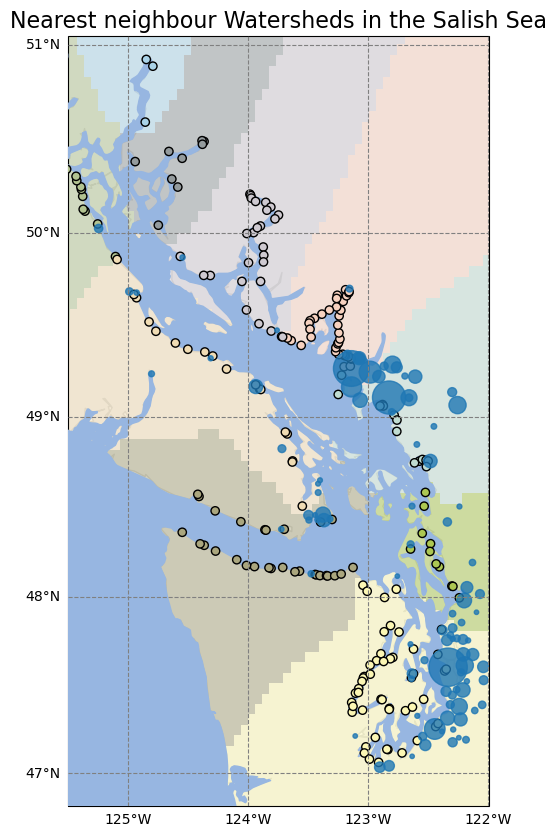

In [30]:
import matplotlib.pyplot as plt
#import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay

#keys = ['howe', 'jdf', 'puget', 'skagit', 'fraser', 'evi_n', 'jervis', 'toba', 'bute', 'evi_s']
Rivers_list = Rivers_list[['Name','Watershed','Longitude','Latitude']]
n_neighbors = 5

# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = Rivers_list.iloc[:,2:4]
y = cclas

# Create color maps
cmap_light = ListedColormap(['#F6D1BF','#AAA67E','#FCF7B4','#ACC752','#C0DCD1','#B2C391','#CFCAD1','#949B9D','#AAD3E8','#F0DCB4'])
cmap_bold = ['#F6D1BF','#AAA67E','#FCF7B4','#ACC752','#C0DCD1','#B2C391','#CFCAD1','#949B9D','#AAD3E8','#F0DCB4']

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights="distance")
clf.fit(X, y)

lonmin= Rivers_deploy.Longitude.min()-0.25
lonmax= Rivers_deploy.Longitude.max()+0.25
latmin= Rivers_deploy.Latitude.min()-0.25
latmax= Rivers_deploy.Latitude.max()+1
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='#F0F0F0',edgecolor='lightgray'),zorder=1)
ax.add_feature(feature.OCEAN,zorder=3)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False
DecisionBoundaryDisplay.from_estimator(
    clf,
    X,
    cmap=cmap_light,
    ax=ax,
    response_method="predict",
    plot_method="pcolormesh",
    xlabel='Latitude',
    ylabel='Longitude',
    alpha=0.5,
    transform=crs.PlateCarree()
)
#plt.gca().invert_yaxis()
# Plot also the training points
cit=plt.scatter(Urban.Longitude,Urban.Latitude,zorder=5,alpha=0.8,s=Urban.Population/1e3,transform=crs.PlateCarree())
riv=plt.scatter(Rivers_list.Longitude,Rivers_list.Latitude,transform=crs.PlateCarree(),zorder=4,c = cc,edgecolors='k')
plt.title('Nearest neighbour Watersheds in the Salish Sea',fontsize='16')
plt.show()

In [31]:
Rivers_deploy.sort_values(by = 'Population_polluting',ascending = False)

,Name,Watershed,Latitude,Longitude,Population_polluting
114,Duwamish2,puget,47.591957092285156,-122.34629821777344,1392720
7,FalseCreek,howe,49.27677917480469,-123.1474380493164,911373
127,Nicomekl,fraser,49.058143615722656,-122.87136840820312,568322
112,Hylebas,puget,47.28432083129883,-122.41390228271484,484510
126,Serpentine,fraser,49.06599807739258,-122.87809753417969,322574
136,Lakethingo,fraser,48.755367279052734,-122.49676513671875,305103
128,LittleCampbell,fraser,49.008460998535156,-122.78111267089844,293641
123,SnohomishAllenQuilceda,skagit,47.9940071105957,-122.23646545410156,279680
0,Edmonds port,puget,47.815885,-122.385012,264210
4,Victoria Harbor,jdf,48.41695,-123.395355,238710


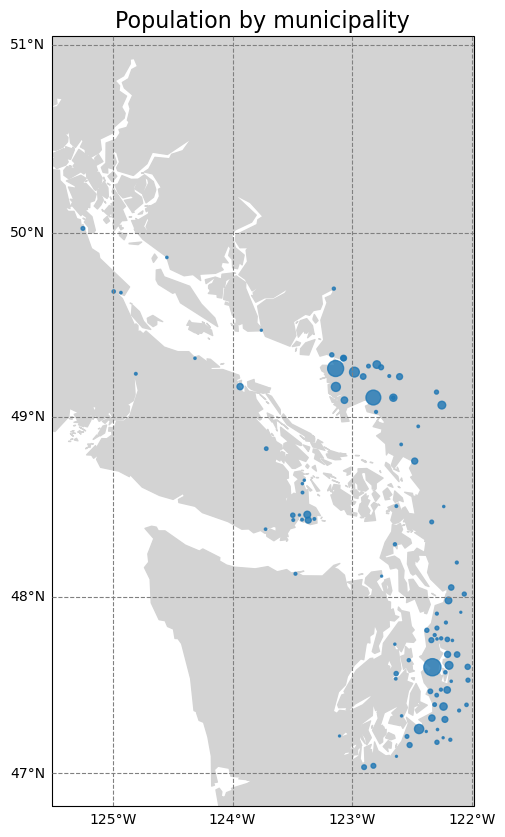

In [32]:
lonmin= Rivers_deploy.Longitude.min()-0.25
lonmax= Rivers_deploy.Longitude.max()+0.25
latmin= Rivers_deploy.Latitude.min()-0.25
latmax= Rivers_deploy.Latitude.max()+1
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='lightgray',edgecolor='lightgray'),zorder=1)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False
plt.title('Population by municipality',fontsize='16')
sc=plt.scatter(Urban.Longitude,Urban.Latitude,transform=crs.PlateCarree(),zorder=2,alpha=0.8,s=Urban.Population/5e3)

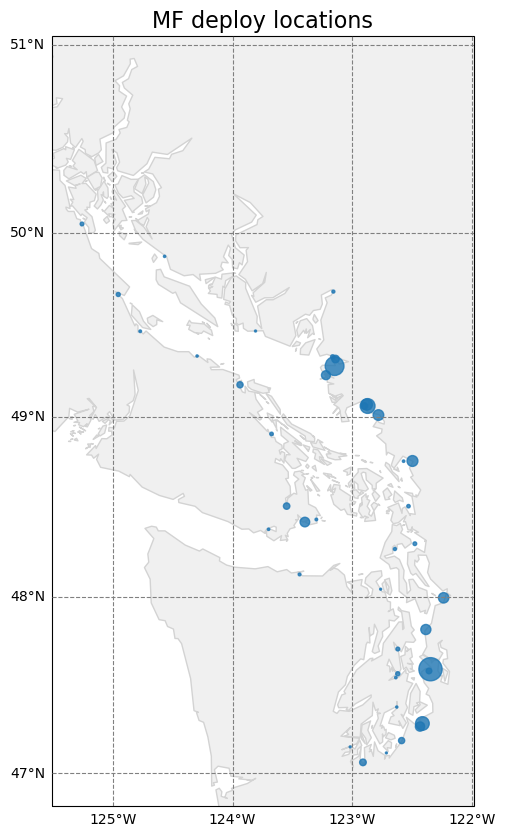

In [33]:
lonmin= Rivers_deploy.Longitude.min()-0.25
lonmax= Rivers_deploy.Longitude.max()+0.25
latmin= Rivers_deploy.Latitude.min()-0.25
latmax= Rivers_deploy.Latitude.max()+1
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='#F0F0F0',edgecolor='lightgray'),zorder=1)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False
plt.title('MF deploy locations',fontsize='16')
sc=plt.scatter(Rivers_deploy.Longitude,Rivers_deploy.Latitude,transform=crs.PlateCarree(),zorder=2,alpha=0.8,s=Rivers_deploy.Population_polluting/5e3)

In [34]:
def pandas_deploy(N,MFc,dtp):
    MFc = float(MFc)
    Rivers_deploy = pd.read_csv(N, index_col = [0])
    Pol = list(Rivers_deploy.Population_polluting)
    Lat = Rivers_deploy.Latitude
    Lon = Rivers_deploy.Longitude
    clat = []
    clon = []
    for i,loc in enumerate(Pol):
        for j in range(int(round((loc*250*dtp)/MFc,0))):
            clat.append(Lat.iat[i])
            clon.append(Lon.iat[i])
    return clat, clon, len(clat)   


def p_deploy(N,n,dmin,dd,r = 1000):
    #r is radius of particle cloud [m]
    deg2m = 111000 * np.cos(50 * np.pi / 180)
    var = (r / (deg2m * 3))**2
    x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], [n,N]).T
    if isinstance(dmin,int):
        zvals1 = dmin + np.random.random_sample([n,N]).T*(dd)
    else:
        zvals = []
        zvals1 = []
        for dept in dmin:
            zvals.append(dept + np.random.random_sample([n]).T*(dd))
        for i in range(len(zvals)):   
            zvals1=np.concatenate((zvals1[:],zvals[i]))
    return x_offset, y_offset, zvals1  

In [35]:
n = 1
N =  '/users/jvalenti/MOAD/analysis-jose/OParcels/Deploy_locations.csv' 
MFc = 1e6
dtp = 10
r = 1
dmin= 3 #minimum depth
dd= 2 #max depth difference from dmin
clat, clon, N =  pandas_deploy(N,MFc,dtp)

x_offset, y_offset, z = p_deploy(N,n,dmin,dd,r)

lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])
    

In [36]:
import xarray as xr
import cmocean
Bath =  xr.open_dataset('/users/jvalenti/MOAD/grid/bathymetry_202108.nc')
cmap = cmocean.cm.deep

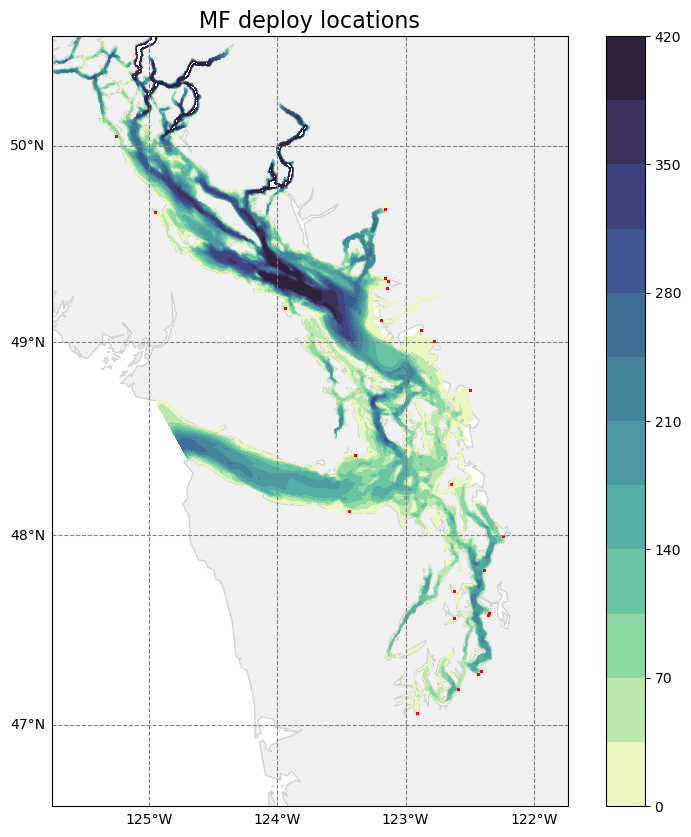

In [37]:
%matplotlib inline
lonmin= lon.min()-0.5
lonmax=  lon.max()+0.5
latmin= lat.min()-0.5
latmax= lat.max()+0.5
blevels = list(np.arange(0,450,35))
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': crs.Mercator()})
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=crs.PlateCarree())
ax.add_feature(feature.GSHHSFeature('intermediate', facecolor='#F0F0F0',edgecolor='lightgray'),zorder=1)
im=ax.contourf(Bath.nav_lon, Bath.nav_lat, Bath.Bathymetry,zorder=1,transform=crs.PlateCarree(),cmap=cmap,levels=blevels)
plt.colorbar(im)
gl = ax.gridlines(
    linestyle='--', color='gray', draw_labels=True,
    xlocs=np.arange(int(lonmin),int(lonmax),1), ylocs=np.arange(int(latmin),ceil(latmax),1),zorder=5)
gl.top_labels, gl.right_labels = False, False
plt.title('MF deploy locations',fontsize='16')
sc=plt.scatter(lon,lat,transform=crs.PlateCarree(),zorder=2,alpha=0.8,s = 0.1,c='r')

In [38]:
#campbell=[(50.048692°N, 125.255410°W)]
#HOWE SOUND (49.658025°N, 124.935567°W)
#nanaimo (49.1688949N, 123.921236°W)
#victoria harbor (48.410722°N, 123.393503°W)
#Juandefuca US (48.134593°N, 123.428613°W)



In [39]:
latmin = 48.26658852559821
lonmin =    -122.64355302372503
jjii = xr.open_dataset('~/MOAD/grid/grid_from_lat_lon_mask999.nc')
j = [jjii.jj.sel(lats=latmin, lons=lonmin, method='nearest').item()]
i = [jjii.ii.sel(lats=latmin, lons=lonmin, method='nearest').item()]

In [40]:
print(j,i)

[219] [285]


In [41]:
Rivers_deploy = pd.read_csv('/users/jvalenti/MOAD/analysis-jose/OParcels/Deploy_locations.csv' , index_col = [0])

In [42]:
Rivers_deploy

,Name,Watershed,Latitude,Longitude,Population_polluting
0,Edmonds port,puget,47.815885,-122.385012,103300
1,Oak Harbor,skagit,48.266780,-122.643507,24760
4,Victoria Harbor,jdf,48.416950,-123.395355,117735
7,FalseCreek,howe,49.276779,-123.147438,662248
8,FirstNarrows,howe,49.315445,-123.139832,146288
10,Lawson,howe,49.327332,-123.163666,44122
27,Stawanus,howe,49.682247,-123.157562,23819
49,Tumwater,jdf,48.124725,-123.439880,20200
94,ClearBarker,puget,47.566296,-122.619514,45220
95,BigValley,puget,47.705952,-122.619026,25060
